# Colapse all simulation into a unique .feather file

In [2]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex1/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    df_all.to_feather(df_complete_file)

params_list = ['cycle_tumor_sat','cycle_tumor_hfm','cycle_tumor_hp',
                   'mechano_tumor_hfm','mechano_tumor_hp',
                   'necrosis_tumor_hfm','necrosis_tumor_hp',
                   'tumor2motile_hfm','tumor2motile_hp',
                   'cycle_motile_sat', 'cycle_motile_hfm', 'cycle_motile_hp',
                   'mechano_motile_hfm', 'mechano_motile_hp',
                   'necrosis_motile_hfm', 'necrosis_motile_hp',
                   'motile2tumor_sat', 'motile2tumor_hfm', 'motile2tumor_hp']
df_all # 183920 rows = 152 samples * 10 repplicates * 121 time points

df_complete_ex1.feather already exists. Reading it.


,time,replicate,sample,runtime,tumor_live,tumor_dead,motile_live,motile_dead,dist_tumor_live,dist_tumor_dead,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0.0,4,107,0.000019,2000,0,0,0,"[77.9878646113564, 257.21390187394763, 225.465...",[],...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
1,60.0,4,107,1.009026,1924,37,49,1,"[73.18934881001186, 259.1817177692407, 232.719...","[330.86966679363417, 209.19706740196096, 58.95...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
2,120.0,4,107,2.049730,1879,58,76,2,"[76.92169181692447, 259.72315067448596, 235.02...","[330.5687468157667, 30.294812203799566, 213.07...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
3,180.0,4,107,3.075330,1830,76,108,4,"[260.4245099355263, 236.34011074261932, 316.35...","[78.87116893672855, 330.61392855684596, 33.554...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
4,240.0,4,107,4.100399,1794,94,129,7,"[261.87585400551524, 237.74671696750653, 316.2...","[82.1607379287901, 113.9423668014618, 330.6959...",...,0.00056,17.2,3.2,0.2,2.28,3.00,6.4,0.004,5.4,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185125,6960.0,6,114,170.303300,1844,338,105,80,"[294.68509713812335, 402.9800486714981, 322.24...","[80.23184379399002, 234.14188836524113, 98.885...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185126,7020.0,6,114,171.951886,1855,340,100,80,"[294.32372585043333, 403.2534543617331, 321.72...","[81.42580074308741, 233.6395739895814, 99.4900...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185127,7080.0,6,114,173.594218,1865,335,99,80,"[293.9464474465499, 403.42077302881916, 322.11...","[81.05038322056353, 233.80589350543497, 99.226...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4
185128,7140.0,6,114,175.233674,1877,338,90,80,"[293.51856763888105, 403.570533588793, 322.898...","[80.20369078836694, 234.25601638624298, 98.829...",...,0.00056,17.2,3.2,0.2,2.40,3.03,6.4,0.004,5.4,6.4


# Define the QoIs: AUC of each mean population, weithed mean and pooled std of distance from the center in the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pooling the distances from replicates and calculate the Wassertein distance between tumor and motile.


In [3]:
df_summary_file = 'df_summary_ex1.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) ):
    print(f'{df_summary_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
else:
    print(f'{df_summary_file} does not exists. Generating it.')

    # Exclude columns with numpy arrays before calculating the mean
    exclude_cols = ['dist_tumor_live', 'dist_tumor_dead', 'dist_motile_live', 'dist_motile_dead']
    df_summary_temp = df_all.drop(columns=exclude_cols).groupby(['sample', 'time'], as_index=False).mean()
    df_summary_temp = df_summary_temp.drop(columns=['replicate'])

    # Replace the mean of distributions to concatenate each replicate samples - row dimension of samples x time points
    for col in exclude_cols:
        concatenated = df_all.groupby(['sample', 'time'])[col].apply(
            lambda x: np.concatenate([y for y in x if y.size > 0 and y.ndim > 0]) if any(y.size > 0 and y.ndim > 0 for y in x) else np.array([])
        ).reset_index(drop=True)
        df_summary_temp[col] = concatenated
    
    # Function to calculate AUC using trapezoidal rule for trajectories
    def calculate_auc_multiple(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead', 'motile_live', 'motile_dead']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapezoid(group[col][mask_notna], group['time'][mask_notna])
        return pd.Series(auc_values)
    # Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
    df_auc = df_summary_temp.groupby(['sample']).apply(calculate_auc_multiple).reset_index() # calculate the AUC for each QOI
    
    # Function to calculate Wasserstein distance between tumor and motile cells 
    def calculate_wassertein_dist(group):
        wasserstein_values = {}
        # Define empirical distributions of tumor and motile cells
        emp_liveTumor_cdf = ecdf(group['tumor_live'].to_numpy())
        emp_liveMotile_cdf = ecdf(group['motile_live'].to_numpy())
        wasserstein_values['Wasserstein_dist'] = wasserstein_distance(emp_liveTumor_cdf.cdf.quantiles, emp_liveMotile_cdf.cdf.quantiles, emp_liveTumor_cdf.cdf.probabilities, emp_liveMotile_cdf.cdf.probabilities)
        return pd.Series(wasserstein_values)
    # Group by 'Sample_ID' then calculate Wasserstein distance between tumor and motile cells - row dimension of samples
    df_distance = df_summary_temp[ df_summary_temp['time'] == 7200.0 ].groupby(['sample']).apply(calculate_wassertein_dist).reset_index()

    # Merge the AUC values and Wasserstein distance to the summary dataframe
    df_summary = df_auc.merge(df_distance, on=['sample'])
    
    # Merge the parameters to the summary dataframe
    df_summary = df_summary.merge(df_summary_temp[ df_summary_temp['time'] == 7200.0 ][['sample']+ params_list], on=['sample'])


    df_summary.to_feather(df_summary_file)

df_summary

df_summary_ex1.feather already exists. Reading it.


,sample,AUC_tumor_live,AUC_tumor_dead,AUC_motile_live,AUC_motile_dead,Wasserstein_dist,cycle_tumor_sat,cycle_tumor_hfm,cycle_tumor_hp,mechano_tumor_hfm,...,cycle_motile_sat,cycle_motile_hfm,cycle_motile_hp,mechano_motile_hfm,mechano_motile_hp,necrosis_motile_hfm,necrosis_motile_hp,motile2tumor_sat,motile2tumor_hfm,motile2tumor_hp
0,0,12274602.0,1838106.0,825684.0,441906.0,1735.0,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
1,1,12262137.0,1871406.0,825015.0,420876.0,1737.4,0.000554,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
2,2,12271776.0,1862319.0,812616.0,444870.0,1727.4,0.000566,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
3,3,12273930.0,1845969.0,823431.0,422313.0,1731.7,0.000532,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
4,4,12316320.0,1815498.0,851280.0,427005.0,1733.0,0.000588,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,148,12338649.0,1822278.0,849003.0,441480.0,1739.8,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,6.72
149,149,12290523.0,1833006.0,834018.0,428778.0,1735.3,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,5.76
150,150,12298029.0,1804083.0,849603.0,444039.0,1733.2,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,7.04
151,151,12283353.0,1851759.0,829011.0,408270.0,1717.8,0.000560,17.2,3.2,0.2,...,0.00056,17.2,3.2,0.2,2.4,3.0,6.4,0.004,5.4,5.12


# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Absolute sensitivity (A unit increase in $\theta_i$ changes the output by $S_{\theta_i}$ units): 
$$S_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}$$
Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{f(\theta^\star)}\cdot \dfrac{\theta^\star}{\theta_i - \theta^\star}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [4]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)

# Calculate the sensitivity index
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_motile_live', 'AUC_motile_dead', 'Wasserstein_dist']
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

Sample with reference parameters:  [5.60e-04 1.72e+01 3.20e+00 2.00e-01 2.40e+00 3.00e+00 6.40e+00 5.40e+00
 6.40e+00 5.60e-04 1.72e+01 3.20e+00 2.00e-01 2.40e+00 3.00e+00 6.40e+00
 4.00e-03 5.40e+00 6.40e+00]
QoI: AUC_tumor_live
	 lowest and highest QoI: 48.0 (necrosis_tumor_hfm) and 47.0 (necrosis_tumor_hfm)
	 lowest and highest SI: 41 (necrosis_tumor_hfm) and 25 (mechano_tumor_hfm)

QoI: AUC_tumor_dead
	 lowest and highest QoI: 47.0 (necrosis_tumor_hfm) and 48.0 (necrosis_tumor_hfm)
	 lowest and highest SI: 113 (necrosis_motile_hfm) and 42 (necrosis_tumor_hfm)

QoI: AUC_motile_live
	 lowest and highest QoI: 63.0 (tumor2motile_hfm) and 64.0 (tumor2motile_hfm)
	 lowest and highest SI: 41 (necrosis_tumor_hfm) and 60 (tumor2motile_hfm)

QoI: AUC_motile_dead
	 lowest and highest QoI: 119.0 (necrosis_motile_hfm) and 120.0 (necrosis_motile_hfm)
	 lowest and highest SI: 74 (cycle_motile_sat) and 113 (necrosis_motile_hfm)

QoI: Wasserstein_dist
	 lowest and highest QoI: 55.0 (necrosis_tumor_

,sample,SA_parameter,SA_delta,SI_AUC_tumor_live,Abs_SI_AUC_tumor_live,SI_AUC_tumor_dead,Abs_SI_AUC_tumor_dead,SI_AUC_motile_live,Abs_SI_AUC_motile_live,SI_AUC_motile_dead,Abs_SI_AUC_motile_dead,SI_Wasserstein_dist,Abs_SI_Wasserstein_dist
0,0,Reference,0.00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
1,1,cycle_tumor_sat,-0.01,0.101551,2.225893e+09,-1.811647,-5.946429e+09,0.081024,1.194643e+08,4.758931,3.755357e+09,-0.138329,-4.285714e+05
2,2,cycle_tumor_sat,0.01,-0.023023,-5.046429e+08,1.317280,4.323750e+09,-1.582688,-2.333571e+09,0.670731,5.292857e+08,-0.438040,-1.357143e+06
3,3,cycle_tumor_sat,-0.05,0.001095,2.400000e+07,-0.085555,-2.808214e+08,0.054573,8.046429e+07,0.886750,6.997500e+08,0.038040,1.178571e+05
4,4,cycle_tumor_sat,0.05,0.067975,1.489929e+09,-0.245992,-8.074286e+08,0.619995,9.141429e+08,-0.674397,-5.321786e+08,-0.023055,-7.142857e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,148,motile2tumor_hp,0.05,0.104357,2.001469e+05,-0.172221,-4.946250e+04,0.564841,7.287187e+04,-0.019280,-1.331250e+03,0.055331,1.500000e+01
149,149,motile2tumor_hp,-0.10,-0.012971,-2.487656e+04,0.027746,7.968750e+03,-0.100934,-1.302187e+04,0.297077,2.051250e+04,-0.001729,-4.687500e-01
150,150,motile2tumor_hp,0.10,0.019086,3.660469e+04,-0.185098,-5.316094e+04,0.289687,3.737344e+04,0.048268,3.332812e+03,-0.010375,-2.812500e+00
151,151,motile2tumor_hp,-0.20,-0.003565,-6.836719e+03,-0.037139,-1.066641e+04,-0.020147,-2.599219e+03,0.380579,2.627812e+04,0.049568,1.343750e+01


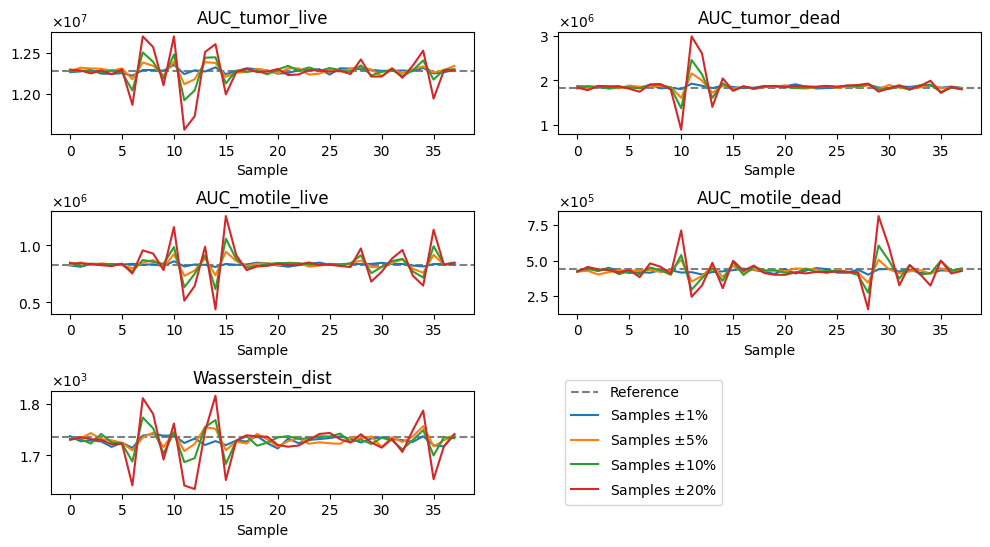

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    ax.axhline(df_summary.iloc[sample_ref][qoi], color='gray', linestyle='--')
    samples_delta1 = df_SA[ (df_SA['SA_delta'] == -0.01) | (df_SA['SA_delta'] == 0.01) ]['sample'].values
    samples_delta5 = df_SA[ (df_SA['SA_delta'] == -0.05) | (df_SA['SA_delta'] == 0.05) ]['sample'].values
    samples_delta10 = df_SA[ (df_SA['SA_delta'] == -0.1) | (df_SA['SA_delta'] == 0.1) ]['sample'].values
    samples_delta20 = df_SA[( df_SA['SA_delta'] == -0.2) | (df_SA['SA_delta'] == 0.2) ]['sample'].values
    ax.plot(range(len(df_summary.iloc[samples_delta1]['sample'])), df_summary.iloc[samples_delta1][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta5]['sample'])), df_summary.iloc[samples_delta5][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta10]['sample'])), df_summary.iloc[samples_delta10][qoi])#, s=12)
    ax.plot(range(len(df_summary.iloc[samples_delta20]['sample'])), df_summary.iloc[samples_delta20][qoi])#, s=12)
    ax.set_title(qoi)
    ax.set_xlabel('Sample')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
axes[2, 1].remove()
plt.legend(labels=['Reference', r'Samples $\pm 1\%$', r'Samples $\pm 5\%$', r'Samples $\pm 10\%$', r'Samples $\pm 20\%$'],loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_90678/1058788702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA['SA_delta'] = df_SA['SA_delta'].round(2)


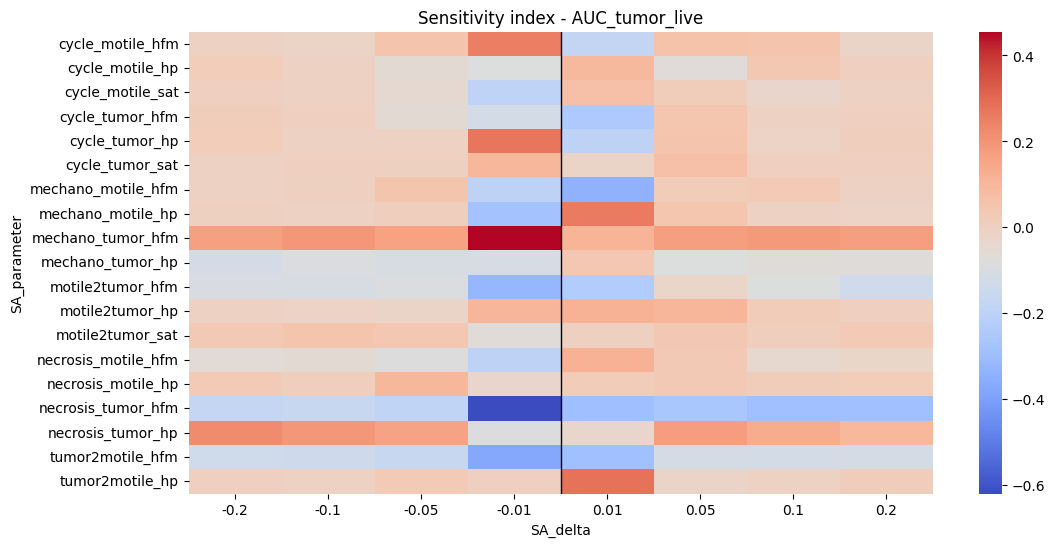

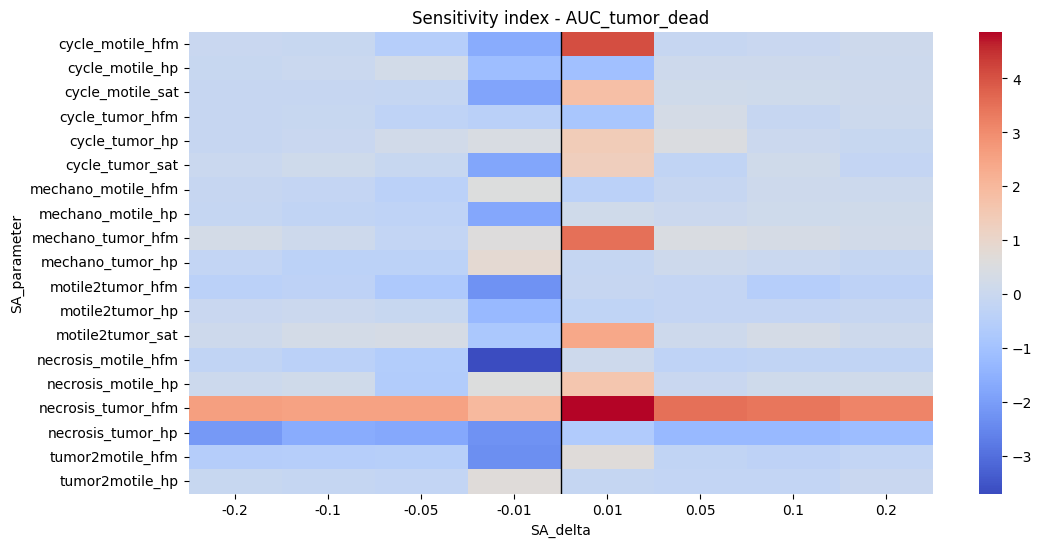

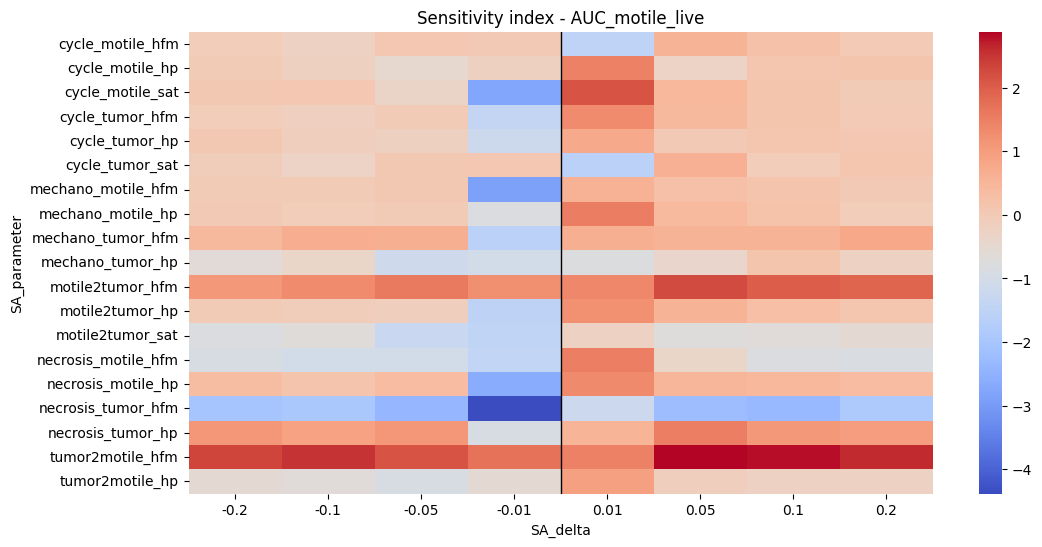

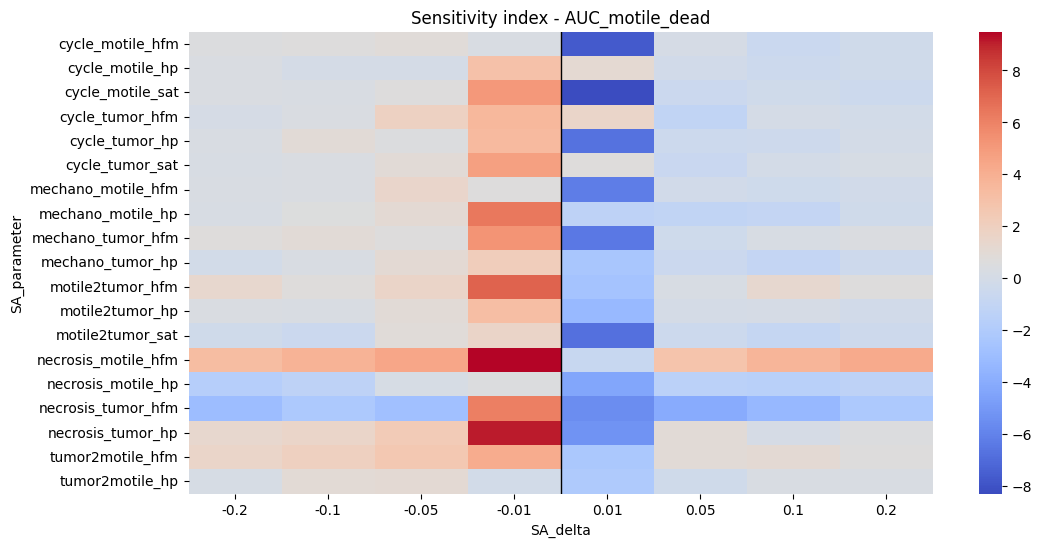

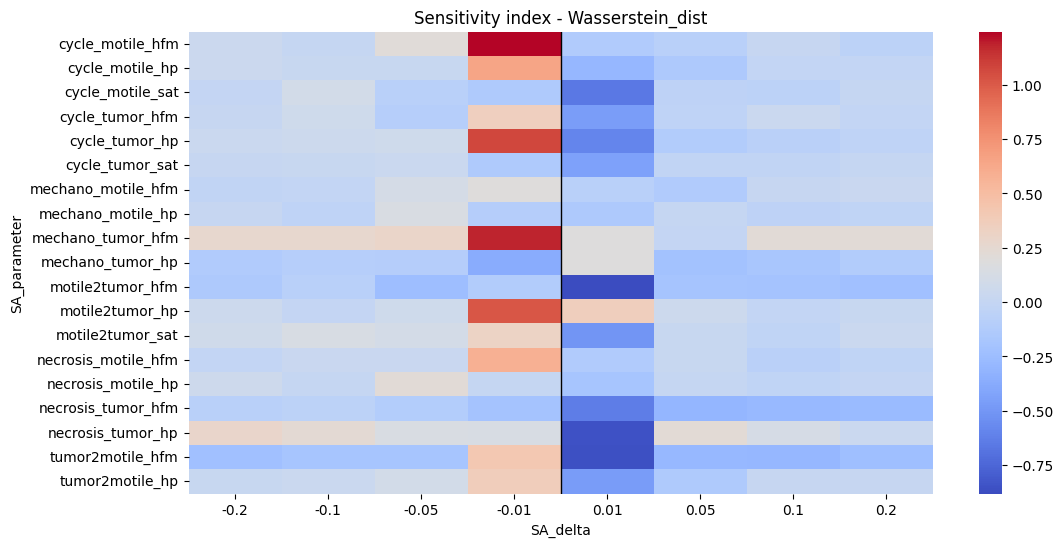

In [19]:
# Plot the sensitivity index as heatmap with the parameters vs delta and color as SI
import seaborn as sns

for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    # Round the values to 2 decimal places
    df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    # Drop the reference sample
    df_SA = df_SA[df_SA['sample'] != sample_ref]
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    sns.heatmap(df_SA_pivot, cmap='coolwarm', ax=ax)
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set_title(f'Sensitivity index - {qoi}')
plt.show()

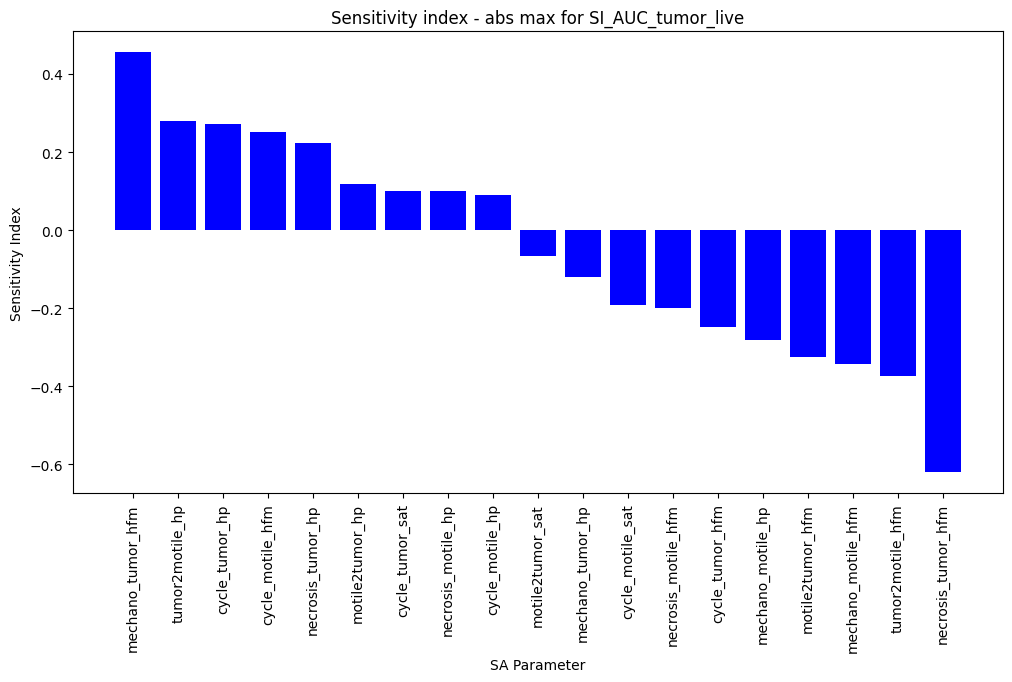

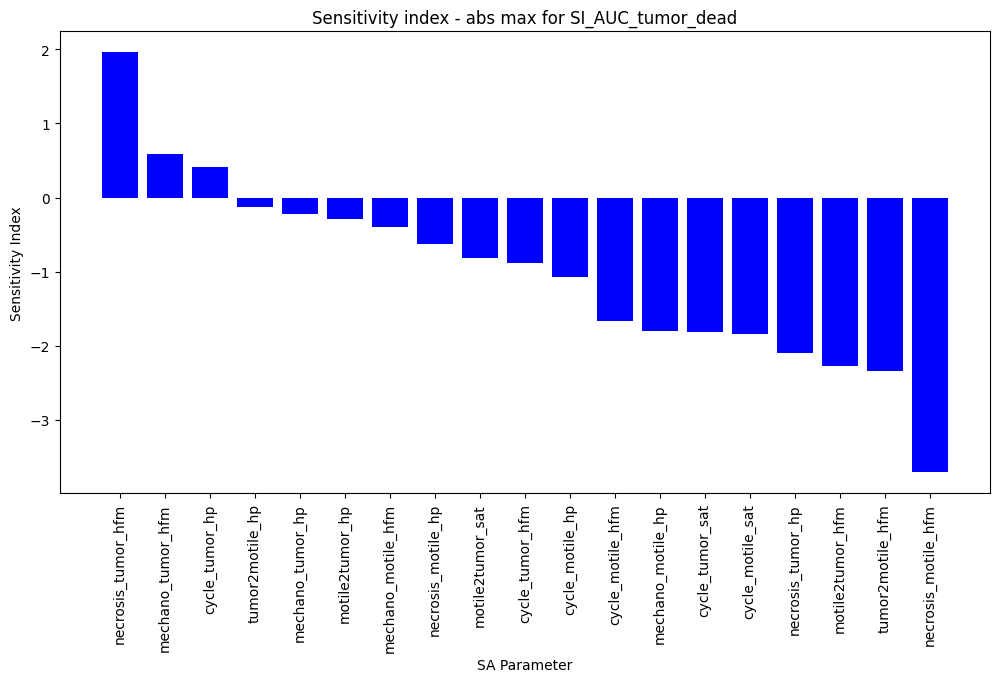

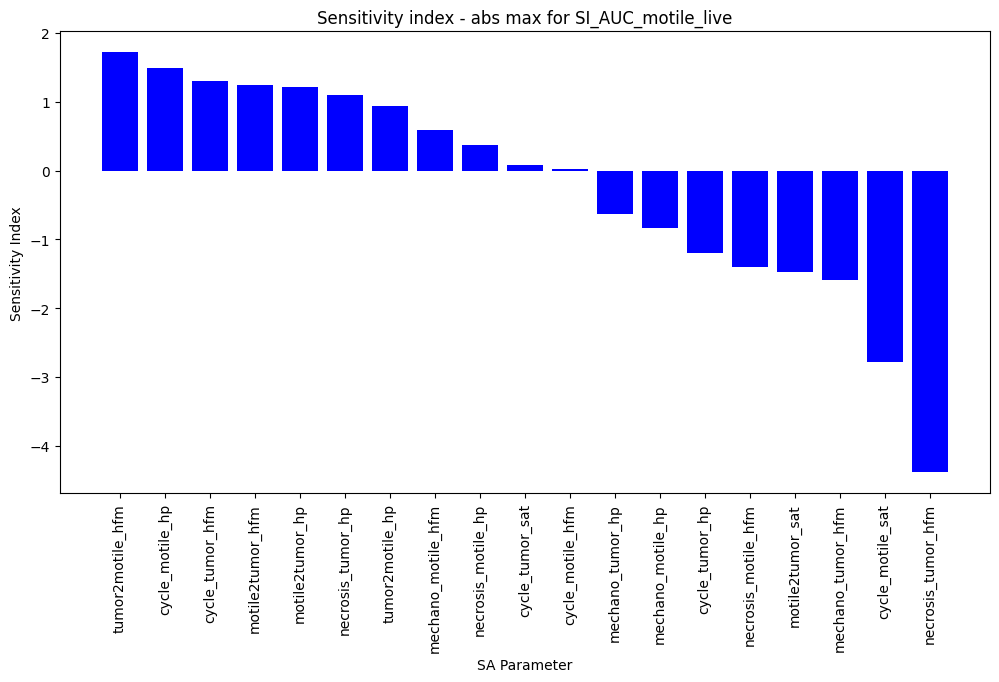

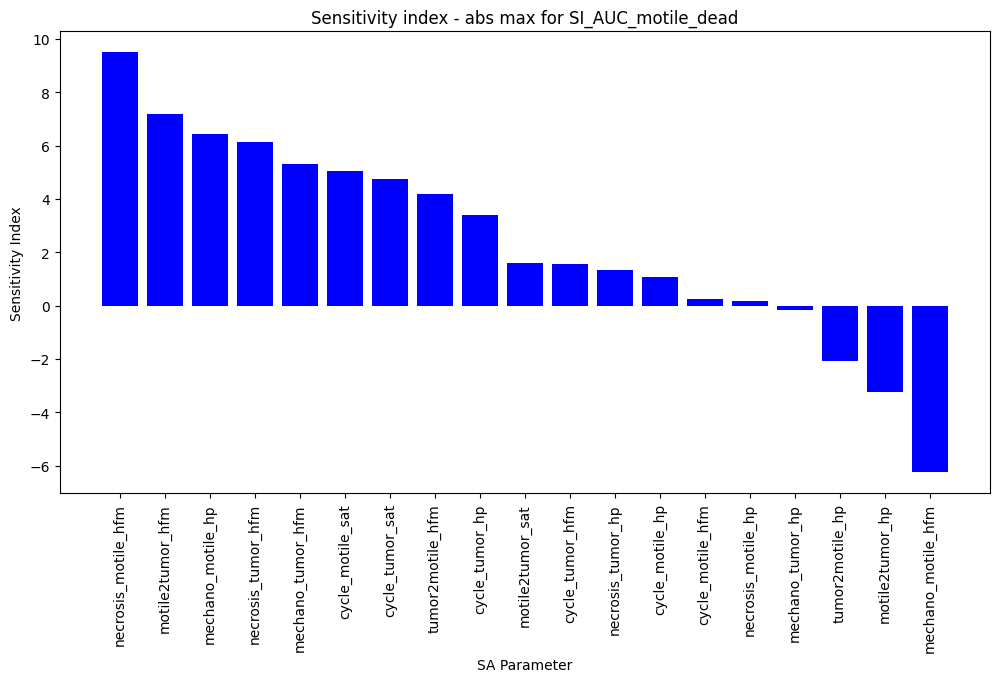

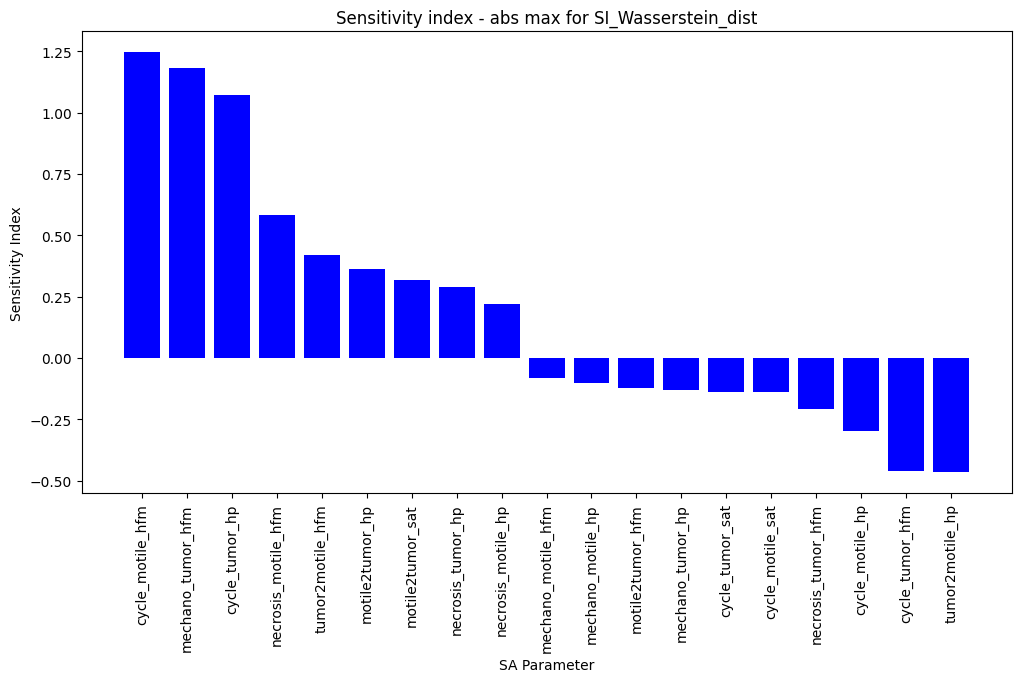

In [20]:
SI_list = [f'SI_{qoi}' for qoi in QoIs_list]

# Round the values to 2 decimal places
df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Calculate the absolute max sensitivity index for each parameter across all SA_delta
df_SA_max = df_SA.groupby(['SA_parameter'])[SI_list].apply(lambda x: x.loc[x.abs().idxmax(axis=0).iloc[0]]).reset_index()

# Pivot the dataframe to get the desired format
# Create a bar plot for each QoI
for qoi in SI_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    df_SA_max_sorted = df_SA_max.sort_values(by=qoi, ascending=False)
    ax.bar(df_SA_max_sorted['SA_parameter'], df_SA_max_sorted[qoi], color='b')
    ax.set_title(f'Sensitivity index - abs max for {qoi}')
    ax.set_xlabel('SA Parameter')
    ax.set_ylabel('Sensitivity Index')
    plt.xticks(rotation=90)
    plt.show()

# Plot one figure with the abs max sensitivity index as heatmap with the parameters vs QOI and color as SI
# fig, ax = plt.subplots(figsize=(12, 6))
# df_SA_pivot = df_SA_max.pivot(index="SA_parameter", columns="SA_delta", values=SI_list)
# sns.heatmap(df_SA_pivot, cmap='coolwarm', ax=ax)
# ax.set_title('Sensitivity index - abs max')
# plt.show()